In [28]:
# # enable widget
# from google.colab import output
# output.enable_custom_widget_manager()
# !pip install ipympl

In [29]:
#Imports
import numpy as np
import heapq
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import ipympl
from google.colab import drive
import scipy.io

In [30]:
mat = scipy.io.loadmat('test.mat')
matGrid = mat["x"]

In [31]:
# Problem Parameters
start = (0,0,0)
end = (0,0,50)
x_range = np.linspace(0, 100, num=101)
x_diff = x_range[1] - x_range[0]
y_range = np.linspace(0, 100, num=101)
y_diff = y_range[1] - y_range[0]
z_range = np.linspace(0, 100, num=101)
z_diff = z_range[1] - z_range[0]
yaw_range = np.linspace(0, 360, num=361)
yaw_diff = yaw_range[1] - yaw_range[0]

In [32]:
# Problem Parameters from Matlab File
start = (0, 0, 0)
end = (len(matGrid), len(matGrid[0]), len(matGrid[0][0]))
x_range = np.linspace(0, len(matGrid), num = len(matGrid) + 1)
x_diff = x_range[1] - x_range[0]
y_range = np.linspace(0, len(matGrid[0]), num = len(matGrid[0]) + 1)
y_diff = y_range[1] - y_range[0]
z_range = np.linspace(0, len(matGrid[0][0]), num = len(matGrid[0][0]) + 1)
z_diff = z_range[1] - z_range[0]
yaw_range = np.linspace(0, len(matGrid[0][0][0]), num = len(matGrid[0][0][0]) + 1)
yaw_diff = yaw_range[1] - yaw_range[0]

In [33]:
# initialize every time! Track grid coords for plotting
gridx = []
gridy = []
gridz = []
visited = []
grid = populateVisitedFromMatLab(visited)

In [34]:
# Dummy Occupancy Grid
def getOGrid():
  oGrid = np.zeros(50*50*50*360).reshape((50, 50, 50, 360)) # x by y by z by yaw 4D grid filled with zeros

  """
  # Make wall
  for i in range(10, 31): #y
    for j in range(10, 31): #z
      for k in range(180): #yaw
        oGrid[25][i][j][k] = 1
  """

  for i in range(0, 5):
    for j in range(0, 5):
      for k in range(180):
        oGrid[i][j][25][k] = 1
        
  return oGrid


In [35]:
# Occupancy Grid from MATLAB File
def populateVisitedFromMatLab(visited):
  oGrid = np.zeros(len(matGrid) * len(matGrid[0]) * len(matGrid[0][0]) * len(matGrid[0][0][0])).reshape(len(matGrid), len(matGrid[0]), len(matGrid[0][0]), len(matGrid[0][0][0]))
  for x in range(len(matGrid)):
    for y in range(len(matGrid[0])):
      for z in range(len(matGrid[0][0])):
        for yaw in range(len(matGrid[0][0][0])):
          if matGrid[x][y][z][yaw] <= 0:
            oGrid[x][y][z][yaw] = 1
            visited.append(Node(x, y, z, yaw, None))
  return oGrid

In [36]:
# Populate Occupancy Grid into Visited List
def populateVisited(visited):
  grid = getOGrid()
  for x in range(len(grid)):
    for y in range(len(grid[0])):
      for z in range(len(grid[0][0])):
        for yaw in range(len(grid[0][0][0])):
          if grid[x][y][z][yaw] == 1:
            visited.append(Node(x, y, z, yaw, None))

In [37]:
class PriorityQueue():
    """Priority Queue credit to CS 188 instructors"""
    def __init__(self):
        self.heap = []
        self.count = 0

    def push(self, item, priority):
        entry = (priority, self.count, item)
        heapq.heappush(self.heap, entry)
        self.count += 1

    def pop(self):
        (_, _, item) = heapq.heappop(self.heap)
        return item

    def isEmpty(self):
        return len(self.heap) == 0
    
    def __str__(self):
        return str([str(x[2]) for x in self.heap])


In [38]:
# Node
class Node():
    def __init__(self, x, y, z, yaw=0, parent=None):
        self.x = x
        self.y = y
        self.z = z
        self.yaw = yaw
        #Parent is used later on to get the path to the end node by backtracking through parents
        self.parent = parent
        
        #self.children = []
        
        #g is backwards cost
        self.g = 0
        #h is heuristic, estimated forward cost
        self.h = 0
        #f is estimated total cost, g + h
        self.f = 0
        
    def __eq__(self, other):
        a = (self.x == other.x)
        b = (self.y == other.y)
        c = (self.z == other.z)
        d = (self.yaw == other.yaw)
        return a and b and c and d
    
    def in_boundaries(self):
      # Returns True if this node is within the boundaries of the map, False otherwise
      return self.x >= 0 and self.x <= x_range[-1] and self.y >= 0 and self.y <= y_range[-1] and self.z >= 0 and self.z <= z_range[-1]

    # Only checks x,y,z coords
    def is_same(self, other):
        a = (self.x == other.x)
        b = (self.y == other.y)
        c = (self.z == other.z)
        return a and b and c

    def get_yaw_dist(self, other):
        yaw_diff = abs(self.yaw - other.yaw)
        if yaw_diff > 180:
          yaw_diff = abs(yaw_diff - 360)
        return yaw_diff
    
    def manhatten(self, other):
        return abs(self.x-other.x) + abs(self.y-other.y) + abs(self.z-other.z) + self.get_yaw_dist(other)
    
    def euclidean(self, other):

        return (self.x-other.x)**2 + (self.y-other.y)**2 + (self.z-other.z)**2 + self.get_yaw_dist(other)
    
    def __str__(self):
        return "Node({}, {}, {}, {})".format(self.x, self.y, self.z, self.yaw)

In [39]:
# Returns ordered list of nodes from start to end
def return_path(n):
    if n.parent is None:
        return [n]
    return return_path(n.parent) + [n]

In [40]:
def search(x_range, y_range, z_range, yaw_range, start, end):
    # Create start and end nodes
    start_node = Node(start[0], start[1], start[2])
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(end[0], end[1], end[2])
    end_node.g = end_node.h = end_node.f = 0
    
    # Initialize lists
    fringe = PriorityQueue()
    visited_list = []
    fringe.push(start_node, start_node.f)
    visited_list.append(start_node)

    populateVisitedFromMatLab(visited_list)
    
    """
    # Process Queue
    while len(yet_to_visit_list > 0):
        
        # Get current node (min f)
        curr_node = yet_to_visit_list[0]
        curr_index = 0
        for index, item in enumerate(yet_to_visit_list):
            if item.f < curr_node.f:
                curr_node = item
                curr_index = index
                
        # Pop current node
        yet_to_visit_list.pop(curr_index)
        visited_list.append(curr_node)
        
        if curr_node == end_node:
            # Fixme
            return return_path()
    """
    #Are these moves right? Can the drone move laterally or does it have to rotate to face the right then move forward to go right?
    moves = [[-x_diff, 0, 0, 0], #go left
             [x_diff, 0, 0, 0], #go right
             [0, -y_diff, 0, 0], #go down
             [0, y_diff, 0, 0], #go up
             [0, 0, -z_diff, 0], #go forwards
             [0, 0, z_diff, 0], #go backwards
             [0, 0, 0, -yaw_diff], #rotate to the right
             [0, 0, 0, yaw_diff]] #rotate to the left

    while not fringe.isEmpty():
        curr_node = fringe.pop()
        print(curr_node)

        if curr_node.is_same(end_node):
            return return_path(curr_node)
        curr_children = []
        for move in moves:
            moveCost = 0
            child_x, child_y, child_z, child_yaw = curr_node.x, curr_node.y, curr_node.z, curr_node.yaw
            if move[0] != 0:
                child_x = curr_node.x + move[0]
                moveCost = x_diff
            elif move[1] != 0:
                child_y = curr_node.y + move[1]
                moveCost = y_diff
            elif move[2] != 0:
                child_z = curr_node.z + move[2]
                moveCost = z_diff
            elif move[3] != 0:
                child_yaw = (curr_node.yaw + move[3]) % 360
                moveCost = yaw_diff
            child_node = Node(child_x, child_y, child_z, child_yaw, curr_node)
            if child_node not in visited_list and child_node.in_boundaries():
                child_node.g = curr_node.g + moveCost
                #Get heuristic -- Manhatten distance? Euclidean?
                child_node.h = child_node.euclidean(end_node)
                #child_node.h = child_node.manhatten(end_node)
                child_node.f = child_node.g + child_node.h
                curr_children.append(child_node)

        for child in curr_children:
            fringe.push(child, child.f)
            # hack to avoid infinite loops
            visited_list.append(child)
      


In [41]:
path = search(x_range, y_range, z_range, yaw_range, start, end)
print([str(x) for x in path])

Node(0, 0, 0, 0)
Node(1.0, 0, 0, 0)
Node(1.0, 1.0, 0, 0)
Node(1.0, 2.0, 0, 0)
Node(2.0, 2.0, 0, 0)
Node(2.0, 2.0, 1.0, 0)
Node(2.0, 2.0, 2.0, 0)
Node(3.0, 2.0, 2.0, 0)
Node(2.0, 3.0, 2.0, 0)
Node(2.0, 2.0, 3.0, 0)
Node(3.0, 3.0, 2.0, 0)
Node(3.0, 2.0, 3.0, 0)
Node(2.0, 3.0, 3.0, 0)
Node(3.0, 3.0, 3.0, 0)
['Node(0, 0, 0, 0)', 'Node(1.0, 0, 0, 0)', 'Node(1.0, 1.0, 0, 0)', 'Node(1.0, 2.0, 0, 0)', 'Node(2.0, 2.0, 0, 0)', 'Node(2.0, 2.0, 1.0, 0)', 'Node(2.0, 2.0, 2.0, 0)', 'Node(3.0, 2.0, 2.0, 0)', 'Node(3.0, 3.0, 2.0, 0)', 'Node(3.0, 3.0, 3.0, 0)']


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
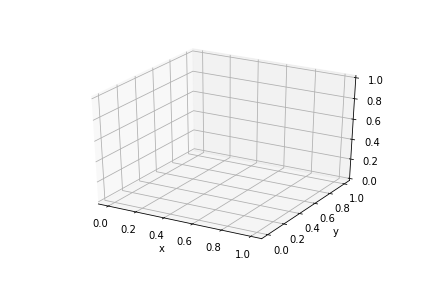

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 1.25}


In [44]:
#%matplotlib widget
x_path = [Node.x for Node in path]
y_path = [Node.y for Node in path]
z_path = [Node.z for Node in path]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
#ax.scatter(x_path,y_path,z_path)

ax.scatter(gridx,gridy,gridz)
plt.xlabel('x')
plt.ylabel('y')
plt.show()